In [1]:
#header file 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from visdom import Visdom
import hiddenlayer as hl

In [2]:
#LeNet
class lenet(nn.Module):
    
    def __init__(self):
        super(lenet, self).__init__()
        #input: [b, 1, 28, 28], output: [b, 6, 28, 28]
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) 
        #input: [b, 6, 28, 28], output: [b, 6, 14, 14]
        self.pool1 = nn.MaxPool2d(2, stride=2)
        #input: [6, 6, 14, 14], output: [b, 16, 10, 10]
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        #input: [6, 16, 10, 10], output: [b, 16, 5, 5]
        self.pool2 = nn.MaxPool2d(2, stride=2)
        #input: [6, 5, 5], output: [120]
        self.fc1 = nn.Linear(16*5*5, 120)
        #input: [120], output: [84]
        self.fc2 = nn.Linear(120, 84)
        #input: [84], output: [10]
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)   
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [3]:
#initialize varince
batch_size = 512
learning_rate = 1e-3
epochs = 10

In [4]:
#load dataset 
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./mnist", train=True, download=True,\
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,),(0.3081,))
        ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./mnist", train=False, download=True,\
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,),(0.3081,))
        ])),
    batch_size=batch_size, shuffle=False)

In [5]:
def plot_image(img, label, name):
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.tight_layout()
        plt.imshow(img[i][0]*0.3081+0.1307, cmap='gray', interpolation='none')
        plt.title("{}: {}".format(name, label[i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

x shape: torch.Size([512, 1, 28, 28]), y shape: torch.Size([512])


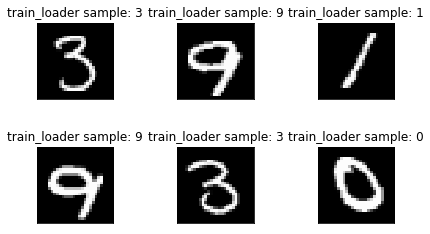

In [6]:
#observe dataset sample 
x, y = next(iter(train_loader))
print('x shape: {}, y shape: {}'.format(x.shape, y.shape))
plot_image(x, y, "train_loader sample")

In [7]:
#use GPU
device = torch.device("cuda:0")

In [8]:
#train lenet model
model = lenet().to(device)
#observe model structure
print(model)

lenet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


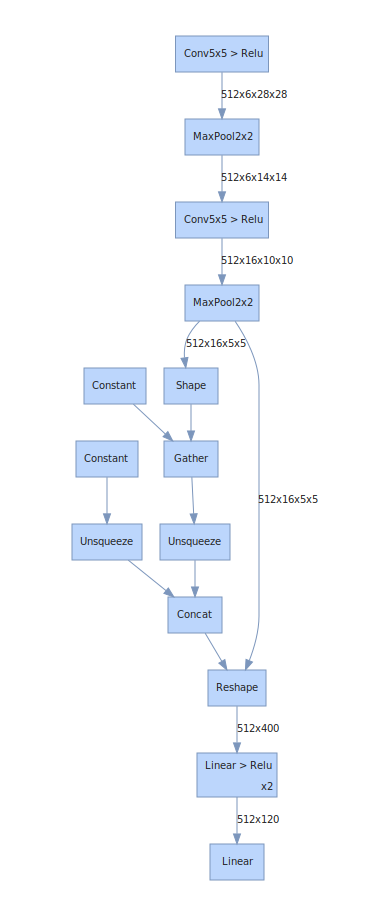

In [9]:
# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([512, 1, 28, 28]).to(device))
# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

In [10]:
#loss function 
criterion = nn.CrossEntropyLoss().to(device)

#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [11]:
#initalize visdom
viz = Visdom()

viz.line([0.], [0.], win='train_loss', opts=dict(title='train loss'))
viz.line([0.], [0.], win='test_loss', opts=dict(title='test loss'))
viz.line([0.], [0.], win='test_acc', opts=dict(title='test acc.'))

'test_acc'

In [13]:
global_step = 0

for epoch in range(epochs):
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #use gpu to caluate
        data, target = data.to(device), target.to(device)
        #train
        logits = model(data)
        loss = criterion(logits, target)
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        global_step += 1
        viz.line([loss.item()], [global_step], win='train_loss', update='append')
        
    print(epoch, 'loss:', loss.item())
    
    model.eval()
    with torch.no_grad():
        total_correct = 0
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            #run
            logits = model(data)
            loss = criterion(logits, target).item()
            test_loss += loss
            pred = logits.argmax(dim=1)
            #
            correct = torch.eq(pred, target).sum().item()
            total_correct += correct
        
        acc = total_correct / len(test_loader.dataset)
        
        viz.line([test_loss], [global_step], win='test_loss', update='append')
        viz.line([acc], [global_step], win='test_acc', update='append')    
        
        print(epoch, "acc: ", acc)

0 loss: 0.35998979210853577
0 acc:  0.9223
1 loss: 0.12496199458837509
1 acc:  0.9634
2 loss: 0.03899361938238144
2 acc:  0.9722
3 loss: 0.010954226367175579
3 acc:  0.9761
4 loss: 0.09025561064481735
4 acc:  0.9796
5 loss: 0.051052678376436234
5 acc:  0.9814
6 loss: 0.050345007330179214
6 acc:  0.9814
7 loss: 0.09537431597709656
7 acc:  0.9839
8 loss: 0.015122349373996258
8 acc:  0.9855
9 loss: 0.009057432413101196
9 acc:  0.9863


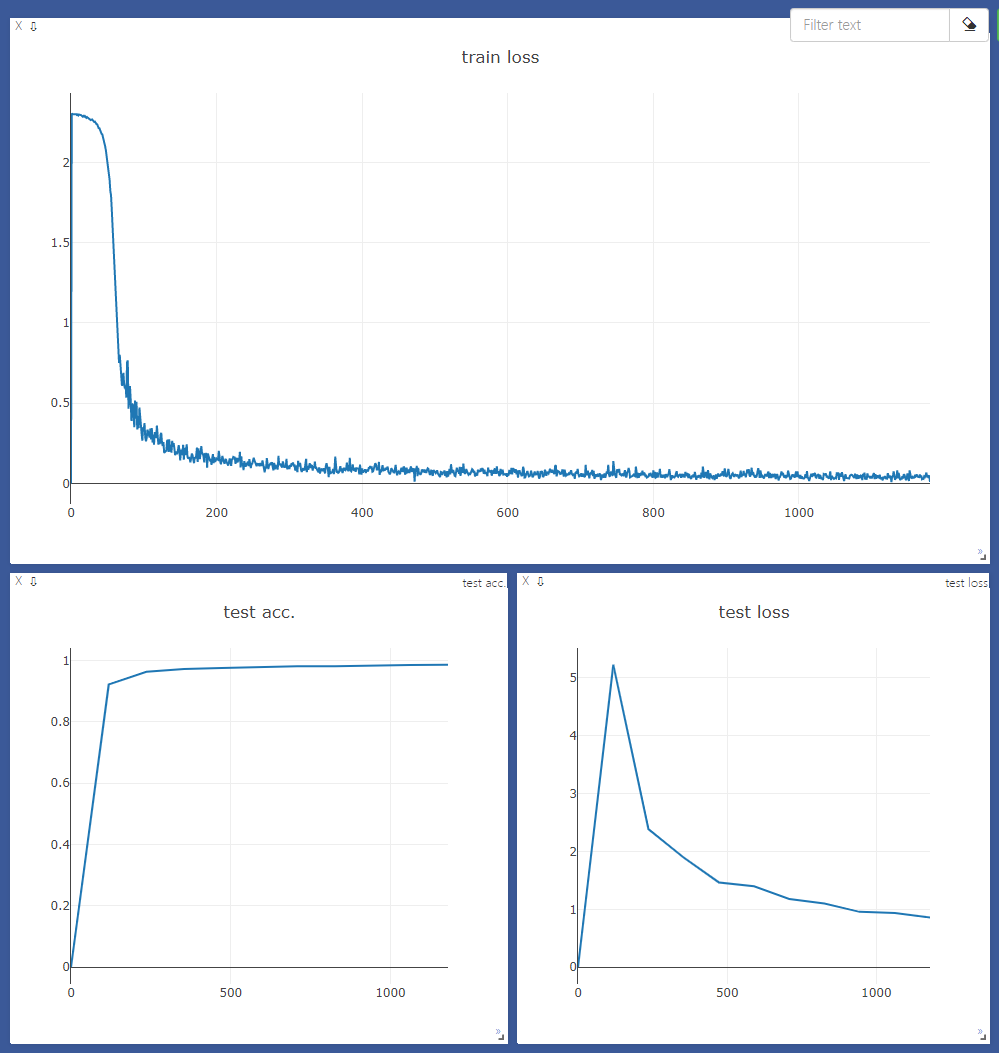